In [8]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import pandas as pd
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), 'figures'))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":16,
                                "axes.labelsize":13})

In [5]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        lambda_no = 1
        has_multiple_lambda = False
        matches_multiple_lambda = re.search(r"(producer|consumer)_(\d+)_(\d+)_(\d+).json", f)
        if matches_multiple_lambda:
            lambda_no = int(matches_multiple_lambda.group(4))
            has_multiple_lambda = True
            matches = matches_multiple_lambda
        else:
            matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            if has_multiple_lambda and run not in data[run_type][file_size]:
                data[run_type][file_size][run] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                if has_multiple_lambda:
                    data[run_type][file_size][run][lambda_no] = json_data
                else:
                    data[run_type][file_size][run] = json_data
    return data

def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            if 'finishedTime' in run_data: # single lambda
                if int(np.log10(run_data['finishedTime'])) == 15:
                    # Convert to ms
                    run_data['finishedTime'] /= 1000
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                if run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime'] < 0.1:
                    deltas[file_size][run_number] = 0.1
                else:
                    deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
                
            else:
                all_finished_times = [lambda_run['finishedTime'] for lambda_run in run_data.values()]
                if int(np.log10(data['producer'][file_size][run_number]['uploadTime'])) == 15:
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                    all_finished_times = [v / 1000 for v in all_finished_times]
                all_deltas = []
                for fin_time in all_finished_times:
                    if fin_time - data['producer'][file_size][run_number]['uploadTime'] < 0:
                        all_deltas.append(0.1)
                    else:
                        all_deltas.append(fin_time - data['producer'][file_size][run_number]['uploadTime'])

                deltas[file_size][run_number] = all_deltas
    return deltas

In [11]:
def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks

## Plot 8 consumers

In [12]:
experiments = {
    "S3": os.path.join(BASE_PATH, "s3"),
    "Redis": os.path.join(BASE_PATH, "redis"),
    "DynamoDB": os.path.join(BASE_PATH, "nat"),
    "TCP": os.path.join(BASE_PATH, "nat"),
}


'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


{0.001: 62.0, 1.0: 65.5, 10.0: 81.0, 100.0: 81.5, 1000.0: 157.5, 10000.0: 323.0, 100000.0: 1930.0}
{0.001: 15.0, 1.0: 23.5, 10.0: 20.5, 100.0: 27.5, 1000.0: 48.0, 10000.0: 298.0, 100000.0: 2630.5}
{0.001: 1.02294921875, 1.0: 1.028076171875, 10.0: 1.0579833984375, 100.0: 13.947021484375, 1000.0: 121.3350830078125, 10000.0: 436.3870849609375, 100000.0: 8400.361572265625}
{0.001: 1.02294921875, 1.0: 1.028076171875, 10.0: 1.0579833984375, 100.0: 13.947021484375, 1000.0: 121.3350830078125, 10000.0: 436.3870849609375, 100000.0: 8400.361572265625}


'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


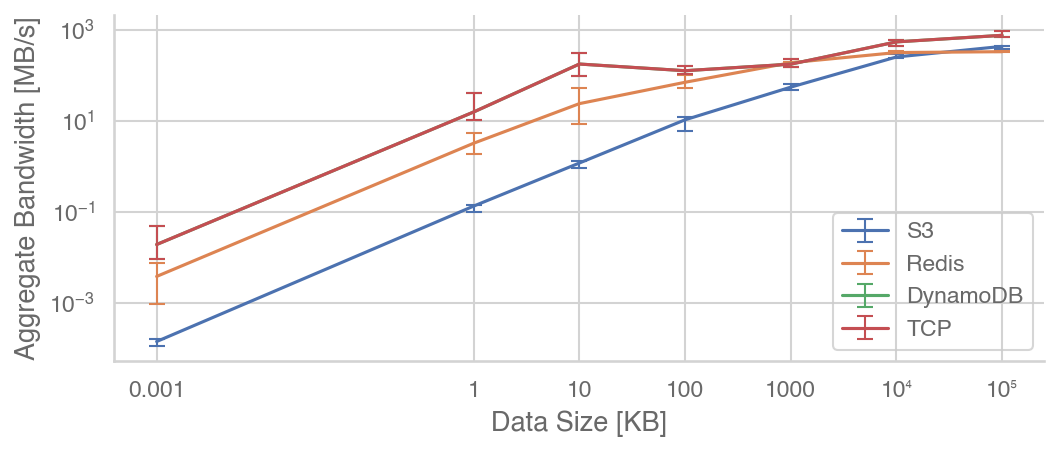

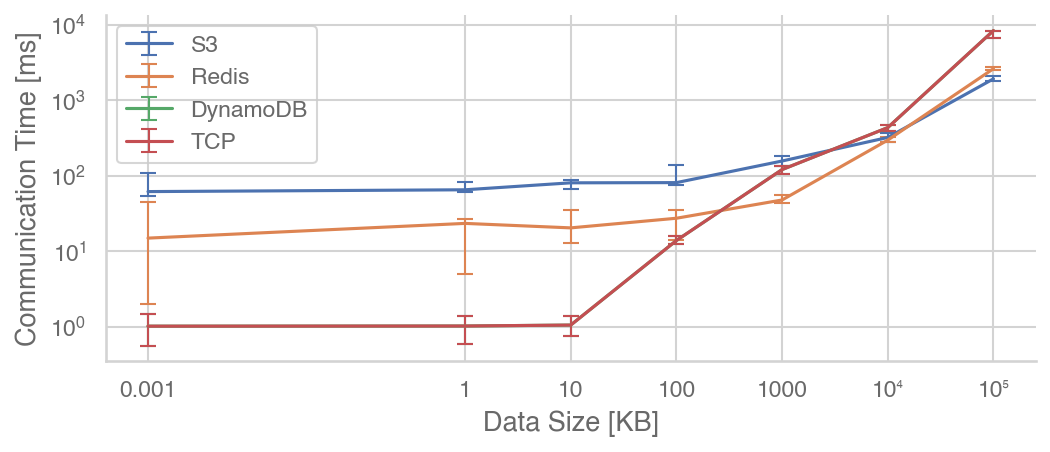

In [13]:
fig, fig2 = plt.figure(figsize=(8,3)), plt.figure(figsize=(8,3))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
one_to_many_performance_means = {}
one_to_many_performance_cis = {}
for experiment_name, exp_base_path in experiments.items():
    one_to_many_performance_means[experiment_name] = {}
    one_to_many_performance_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "one_to_many", "scaling_data", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        agg_bandwidths = []
        for run_arr in values:
            agg_bandwidth = 0
            for latency in run_arr:
                if latency == 0:
                    latency = 1
                agg_bandwidth += (file_size / 1000000) / (latency / 1000)
            #agg_bandwidth /= len(run_arr)
            agg_bandwidths.append(agg_bandwidth)
        val = np.median(agg_bandwidths)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(agg_bandwidths)[-2] - val
        lower_ci = val - np.sort(agg_bandwidths)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Aggregate Bandwidth [MB/s]")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        run_means = []
        run_latencies = []
        for run_arr in values:
            run_latencies.append(np.max(run_arr))
            run_means.append(np.mean(run_arr))
        val = np.median(run_latencies)
        one_to_many_performance_means[experiment_name][file_size / 1000] = np.mean(run_means)
        one_to_many_performance_cis[experiment_name][file_size / 1000] = scipy.stats.sem(run_means) * scipy.stats.t.ppf((1 + 0.95) / 2., len(run_means) - 1)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(run_latencies)[-2] - val
        lower_ci = val - np.sort(run_latencies)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Communication Time [ms]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_bandwidth.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(OUTPUT_PATH, "one-to-many_latency.pdf"), bbox_inches='tight')
plt.show()